# Intelligent Systems - Assignment 2

- Author: Tim Hrovat
- Student no.: 63230112
- Date: 11. 1. 2026

## Introduction

This report presents a comprehensive implementation of natural language processing techniques for detecting contradictions in legal text. The assignment explores the application of various machine learning approaches, progressing from traditional statistical methods to advanced transformer-based models and semantic search systems. All solutions are developed and evaluated using the **English** dataset.

I converted the three-class problem into binary classification (Contradiction vs. Not Contradiction) as the primary goal is identifying contradicting sections for legal professionals. For models, I selected traditional ML algorithms (Logistic Regression, Decision Tree, Random Forest, SVM) as baselines, BERT for its strong contextual understanding, and Legal-BERT for the sentence embedding task due to its pre-training on legal documents.

## Evaluation Metrics

Throughout this assignment, I use several standard classification metrics to evaluate model performance:

- **Accuracy**: The overall proportion of correct predictions across all classes
- **Precision**: What percentage of predicted contradictions are actually contradictions (measures false positive rate)
- **Recall**: What percentage of actual contradictions we successfully identified (measures our ability to catch all contradictions)
- **F1-score**: The harmonic mean of precision and recall, providing a single balanced metric useful for imbalanced datasets
- **Recall@K**: How often the true contradiction appears within the top-K retrieved results (used in the retrieval task)

## Setup & imports

This section imports the essential libraries for running my solutions.

In [12]:
import sys
# uncomment the following line if any of the packages are not installed
!{sys.executable} -m pip install pandas numpy matplotlib scikit-learn seaborn IPython torch transformers datasets 'accelerate>=0.26.0' sentence_transformers

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
from IPython.display import display, HTML
import os
import torch
from torch.utils.data import Dataset, DataLoader as TorchDataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from datasets import Dataset as HFDataset
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from sentence_transformers import models as st_models
from torch.utils.data import DataLoader as STDataLoader

# sklearn sometimes fires unnecessary warnings
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'
sns.set_style('whitegrid')

## Load Data

In [4]:
class DataLoader:
    """Class for loading and initial processing of JSONL data"""
    
    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path
        self.train_data = None
        self.test_data = None
    
    def load_jsonl(self, filepath):
        """Load JSONL file and return list of dictionaries"""
        print(f"Loading data from {filepath}")
        data = []
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                data.append(json.loads(line.strip()))
        return data
    
    def load_all(self):
        """Load both train and test datasets"""
        self.train_data = self.load_jsonl(self.train_path)
        self.test_data = self.load_jsonl(self.test_path)
        print(f"Loaded {len(self.train_data)} training samples and {len(self.test_data)} test samples\n")
        return self.train_data, self.test_data

## Task 1: Data preparation and exploration

For this task I loaded the JSONL datasets and converted them into DataFrames. The data contains premise-hypothesis pairs with labels indicating whether they contradict each other. I transformed the multi-class labels into binary (1 for contradiction, 0 for not), then split the training data into train (85%) and validation (15%) sets using stratification to maintain class balance. To analyze the data I checked for missing values and duplicates, calculated label distribution to assess class balance, and computed text length statistics for both premises and hypotheses. The visualizations include a bar chart showing class distribution, histograms of text lengths in characters and words for both premises and hypotheses, and a summary table with key statistics.

### Implementation

In [5]:
class Task1:
    def __init__(self, train_data, test_data):
        self.train_raw = train_data
        self.test_raw = test_data
        self.train_df = None
        self.val_df = None
        self.test_df = None
        self.full_train_df = None
        
    def prepare_data(self, binary_labels=True):
        print("Preparing data...")
        
        def process_dataset(data):
            processed = []
            for item in data:
                processed.append({
                    'premise': item.get('premise', ''),
                    'hypothesis': item.get('hypothesis', ''),
                    'label': item.get('label', '')
                })
            return pd.DataFrame(processed)
        
        train_df = process_dataset(self.train_raw)
        test_df = process_dataset(self.test_raw)
        
        if binary_labels:
            train_df['binary_label'] = (train_df['label'] == 'Contradiction').astype(int)
            test_df['binary_label'] = (test_df['label'] == 'Contradiction').astype(int)
        
        self.full_train_df = train_df
        self.test_df = test_df
        
        train_df, val_df = train_test_split(
            train_df, 
            test_size=0.15, 
            random_state=42, 
            stratify=train_df['binary_label']
        )
        
        self.train_df = train_df.reset_index(drop=True)
        self.val_df = val_df.reset_index(drop=True)
        
        print(f"Train set: {len(self.train_df)} samples")
        print(f"Validation set: {len(self.val_df)} samples")
        print(f"Test set: {len(self.test_df)} samples\n")
        
        return self.train_df, self.val_df, self.test_df
    
    def exploratory_analysis(self):
        print("Performing exploratory data analysis\n")
        
        df = self.full_train_df.copy()
        
        missing_values = df.isnull().sum()
        duplicates = df.duplicated().sum()
        
        df['premise_length'] = df['premise'].str.len()
        df['hypothesis_length'] = df['hypothesis'].str.len()
        df['premise_words'] = df['premise'].str.split().str.len()
        df['hypothesis_words'] = df['hypothesis'].str.split().str.len()
        
        analysis_results = {
            'total_samples': len(df),
            'missing_values': missing_values.to_dict(),
            'duplicate_entries': duplicates,
            'label_distribution': df['binary_label'].value_counts().to_dict(),
            'class_balance': {
                'contradiction': (df['binary_label'] == 1).sum(),
                'not_contradiction': (df['binary_label'] == 0).sum(),
                'contradiction_pct': ((df['binary_label'] == 1).sum() / len(df) * 100)
            },
            'premise_stats': {
                'mean_chars': df['premise_length'].mean(),
                'median_chars': df['premise_length'].median(),
                'mean_words': df['premise_words'].mean(),
                'median_words': df['premise_words'].median()
            },
            'hypothesis_stats': {
                'mean_chars': df['hypothesis_length'].mean(),
                'median_chars': df['hypothesis_length'].median(),
                'mean_words': df['hypothesis_words'].mean(),
                'median_words': df['hypothesis_words'].median()
            }
        }
        
        return analysis_results, df
    
    def visualize_data(self, df, analysis_results):
        print("Generating visualizations\n")
        
        fig, ax = plt.subplots(figsize=(12, 6))
        label_counts = df['binary_label'].value_counts().sort_index()
        label_names = ['Not Contradiction', 'Contradiction']
        ax.bar(range(len(label_counts)), label_counts.values, color=['#3498db', '#e74c3c'])
        ax.set_title('Binary Label Distribution', fontsize=14, fontweight='bold')
        ax.set_ylabel('Count')
        ax.set_xticks(range(len(label_counts)))
        ax.set_xticklabels(label_names, rotation=45)
        for i, v in enumerate(label_counts.values):
            ax.text(i, v + 50, str(v), ha='center', fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.hist(df['premise_length'], bins=50, color='#2ecc71', alpha=0.7, edgecolor='black')
        ax.axvline(df['premise_length'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        ax.axvline(df['premise_length'].median(), color='blue', linestyle='--', linewidth=2, label='Median')
        ax.set_title('Premise Length Distribution (Characters)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Length')
        ax.set_ylabel('Frequency')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.hist(df['hypothesis_length'], bins=50, color='#f39c12', alpha=0.7, edgecolor='black')
        ax.axvline(df['hypothesis_length'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        ax.axvline(df['hypothesis_length'].median(), color='blue', linestyle='--', linewidth=2, label='Median')
        ax.set_title('Hypothesis Length Distribution (Characters)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Length')
        ax.set_ylabel('Frequency')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.hist(df['premise_words'], bins=30, color='#9b59b6', alpha=0.7, edgecolor='black')
        ax.axvline(df['premise_words'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        ax.set_title('Premise Length Distribution (Words)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Word Count')
        ax.set_ylabel('Frequency')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.hist(df['hypothesis_words'], bins=30, color='#1abc9c', alpha=0.7, edgecolor='black')
        ax.axvline(df['hypothesis_words'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        ax.set_title('Hypothesis Length Distribution (Words)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Word Count')
        ax.set_ylabel('Frequency')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        label_by_length = df.groupby(pd.cut(df['premise_length'], bins=5))['binary_label'].value_counts().unstack()
        label_by_length.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'])
        ax.set_title('Label Distribution by Premise Length', fontsize=14, fontweight='bold')
        ax.set_xlabel('Premise Length Range')
        ax.set_ylabel('Count')
        ax.legend(title='Label', labels=['Not Contradiction', 'Contradiction'])
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()
        
        html_table = f"""
        <h3>Data Analysis Summary</h3>
        <table border="1" style="border-collapse: collapse; width: 100%; margin: 20px 0;">
            <tr style="background-color: #3498db; color: white;">
                <th style="padding: 10px;">Metric</th>
                <th style="padding: 10px;">Value</th>
            </tr>
            <tr>
                <td style="padding: 8px;"><b>Total Samples</b></td>
                <td style="padding: 8px;">{analysis_results['total_samples']}</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 8px;"><b>Duplicate Entries</b></td>
                <td style="padding: 8px;">{analysis_results['duplicate_entries']}</td>
            </tr>
            <tr>
                <td style="padding: 8px;"><b>Contradiction Samples (1)</b></td>
                <td style="padding: 8px;">{analysis_results['class_balance']['contradiction']}</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 8px;"><b>Not Contradiction Samples (0)</b></td>
                <td style="padding: 8px;">{analysis_results['class_balance']['not_contradiction']}</td>
            </tr>
            <tr>
                <td style="padding: 8px;"><b>Contradiction Percentage</b></td>
                <td style="padding: 8px;">{analysis_results['class_balance']['contradiction_pct']:.2f}%</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 8px;"><b>Mean Premise Length (chars)</b></td>
                <td style="padding: 8px;">{analysis_results['premise_stats']['mean_chars']:.1f}</td>
            </tr>
            <tr>
                <td style="padding: 8px;"><b>Mean Hypothesis Length (chars)</b></td>
                <td style="padding: 8px;">{analysis_results['hypothesis_stats']['mean_chars']:.1f}</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 8px;"><b>Mean Premise Length (words)</b></td>
                <td style="padding: 8px;">{analysis_results['premise_stats']['mean_words']:.1f}</td>
            </tr>
            <tr>
                <td style="padding: 8px;"><b>Mean Hypothesis Length (words)</b></td>
                <td style="padding: 8px;">{analysis_results['hypothesis_stats']['mean_words']:.1f}</td>
            </tr>
        </table>
        """
        
        display(HTML(html_table))

### Test

TASK 1: DATA PREPARATION AND EXPLORATION

Loading data from data/English dataset/train.jsonl
Loading data from data/English dataset/test.jsonl
Loaded 7191 training samples and 2091 test samples

Preparing and formatting data
Train set: 6112 samples
Validation set: 1079 samples
Test set: 2091 samples

Performing exploratory data analysis

Generating visualizations



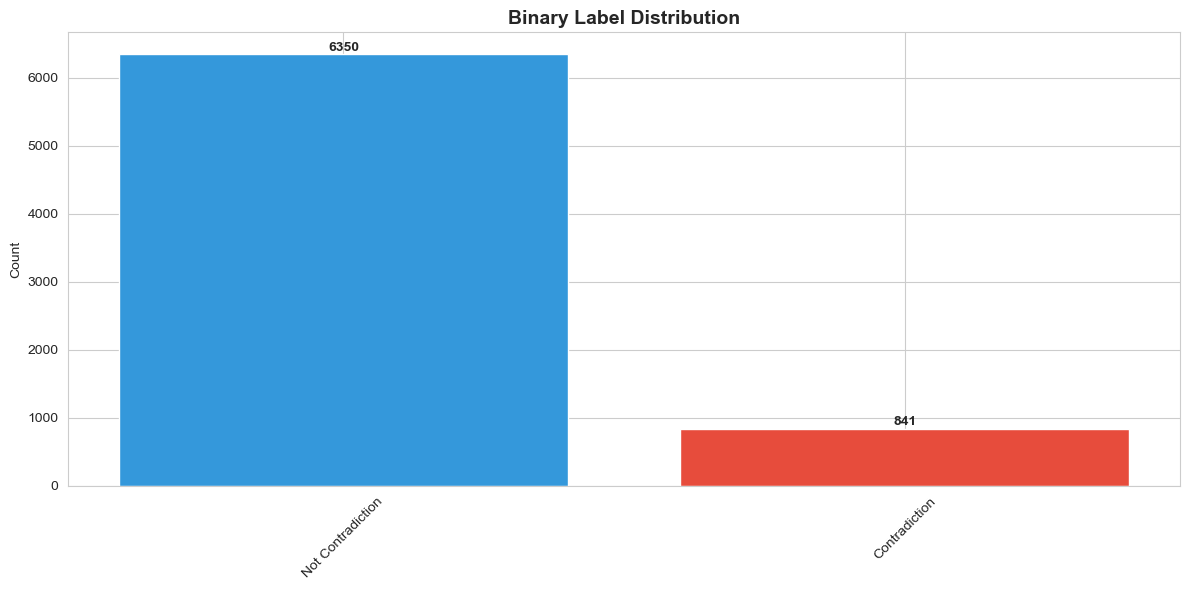

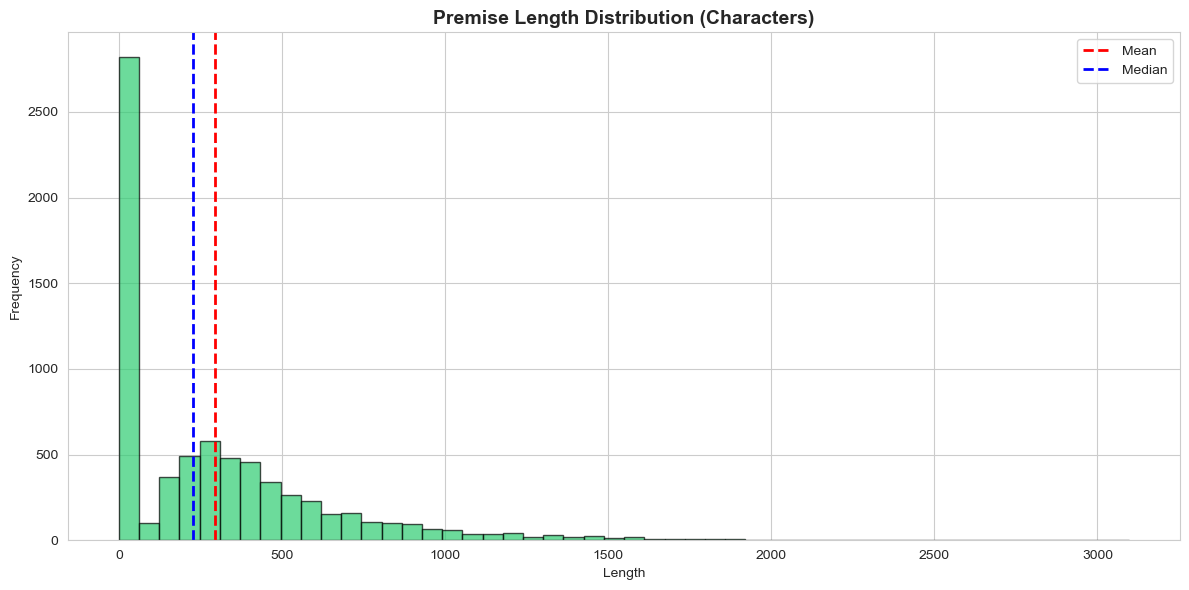

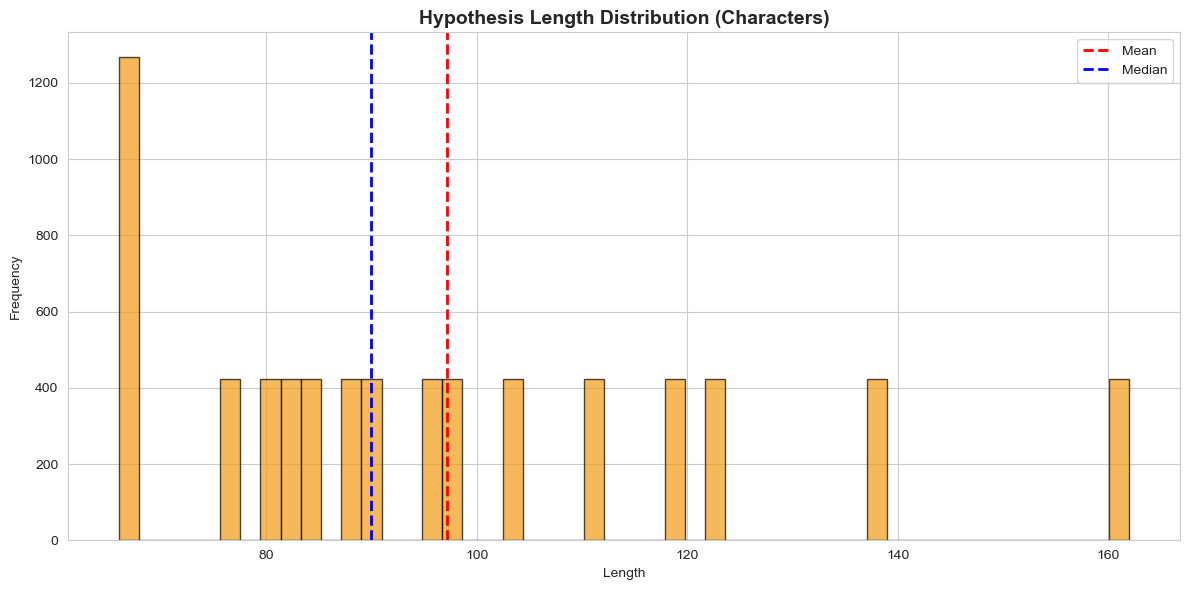

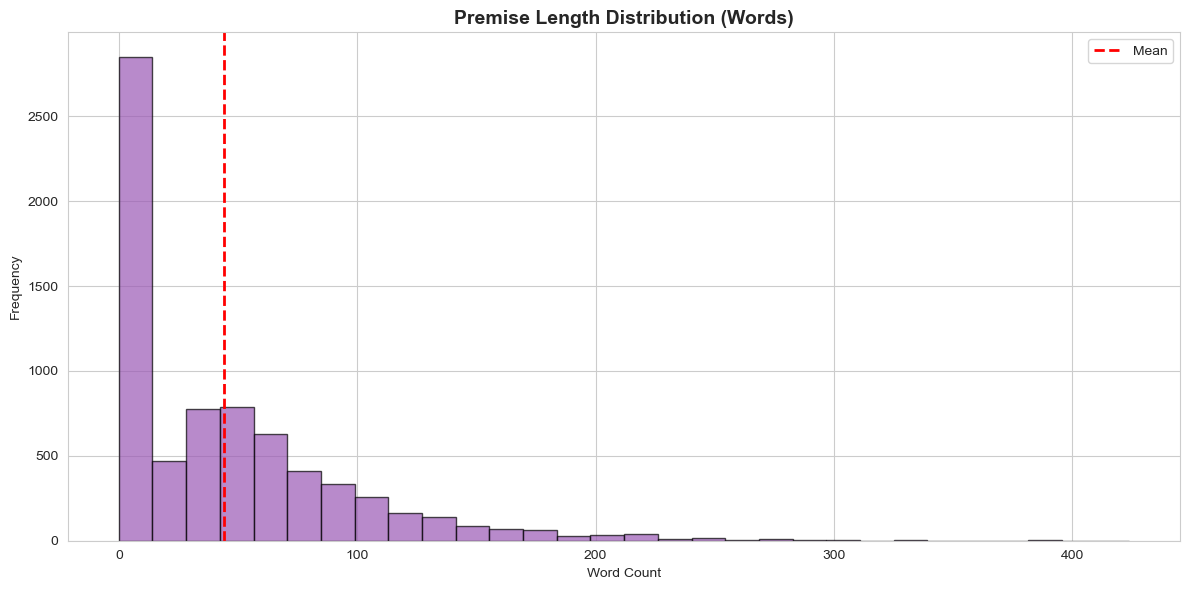

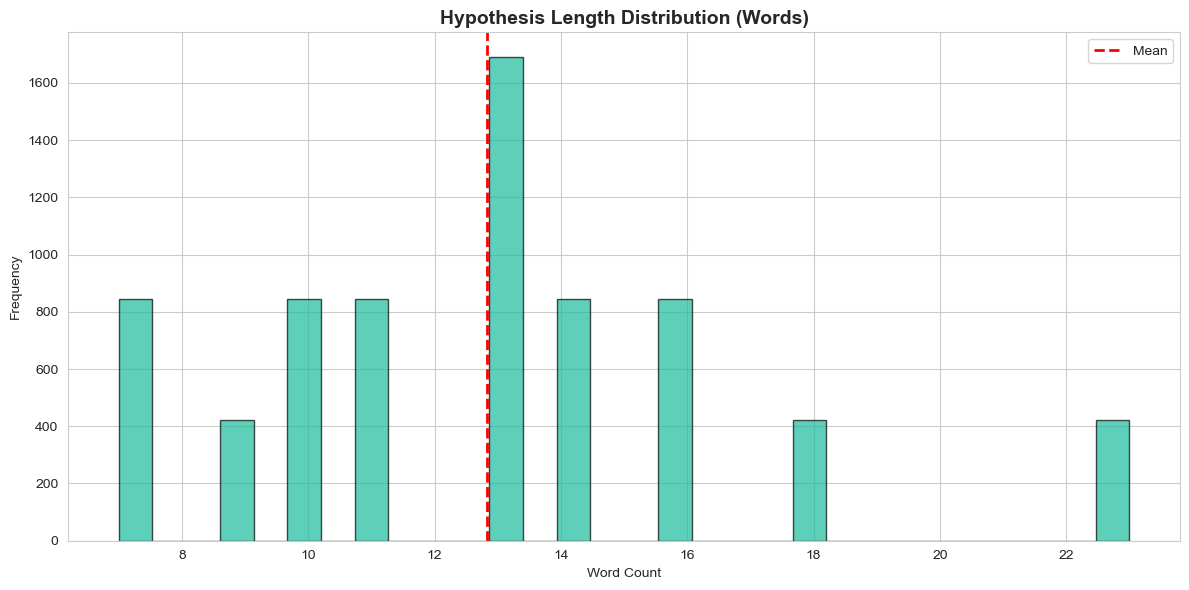

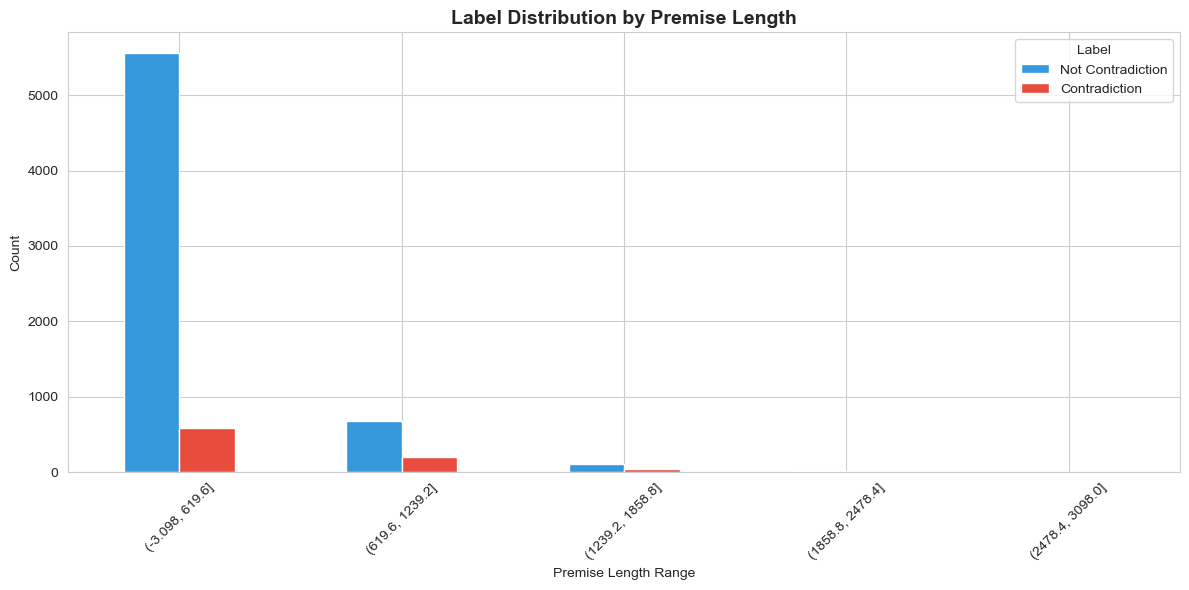

Metric,Value
Total Samples,7191
Duplicate Entries,2882
Contradiction Samples (1),841
Not Contradiction Samples (0),6350
Contradiction Percentage,11.70%
Mean Premise Length (chars),296.3
Mean Hypothesis Length (chars),97.2
Mean Premise Length (words),44.1
Mean Hypothesis Length (words),12.8


TASK 1 COMPLETED SUCCESSFULLY



In [6]:
def task_1_test():
    loader = DataLoader(
        train_path='data/English dataset/train.jsonl',
        test_path='data/English dataset/test.jsonl'
    )
    train_data, test_data = loader.load_all()
    
    task1 = Task1(train_data, test_data)
    
    train_df, val_df, test_df = task1.prepare_data(binary_labels=True)
    
    analysis_results, df_with_stats = task1.exploratory_analysis()
    
    task1.visualize_data(df_with_stats, analysis_results)
    
    return task1, train_df, val_df, test_df

task_1_test();

## Task 2: Basic Machine Learning

For this task I converted the text pairs into numerical features using TF-IDF vectorization, combining each premise and hypothesis with a \[SEP\] separator token. I trained four traditional classifiers: Logistic Regression, Decision Tree, Random Forest, and Linear SVM, using GridSearchCV with 5-fold cross-validation to optimize hyperparameters for each model. After training, I evaluated all models on both validation and test sets using accuracy, precision, recall, F1-score, and ROC-AUC metrics, and generated confusion matrices to analyze prediction patterns. The visualizations compare model performance through accuracy bars, F1-score comparisons between validation and test sets, and confusion matrix heatmaps for each classifier.

### Implementation

In [7]:
class Task2:  
    def __init__(self, train_df, val_df, test_df):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.vectorizer = None
        self.models = {}
        self.results = {}
        
    def prepare_text_features(self, max_features=5000):
        print("Creating TF-IDF features")
        
        self.train_df['combined_text'] = self.train_df['premise'] + ' [SEP] ' + self.train_df['hypothesis']
        self.val_df['combined_text'] = self.val_df['premise'] + ' [SEP] ' + self.val_df['hypothesis']
        self.test_df['combined_text'] = self.test_df['premise'] + ' [SEP] ' + self.test_df['hypothesis']
        
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95,
            sublinear_tf=True
        )
        
        X_train = self.vectorizer.fit_transform(self.train_df['combined_text'])
        X_val = self.vectorizer.transform(self.val_df['combined_text'])
        X_test = self.vectorizer.transform(self.test_df['combined_text'])
        
        y_train = self.train_df['binary_label'].values
        y_val = self.val_df['binary_label'].values
        y_test = self.test_df['binary_label'].values
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def train_logistic_regression(self, X_train, y_train, X_val, y_val):
        print("Training Logistic Regression")
        
        param_grid = {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l2'],
            'max_iter': [1000]
        }
        
        lr = LogisticRegression(random_state=42, solver='lbfgs')
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(lr, param_grid, cv=3, scoring='f1', n_jobs=1, verbose=0)
            grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        self.models['Logistic Regression'] = best_model
        
        y_pred_val = best_model.predict(X_val)
        y_pred_proba_val = best_model.predict_proba(X_val)[:, 1]
        
        metrics = self._calculate_metrics(y_val, y_pred_val, y_pred_proba_val)
        self.results['Logistic Regression'] = metrics
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Validation F1: {metrics['f1']:.4f}\n")
        
        return best_model
    
    def train_random_forest(self, X_train, y_train, X_val, y_val):
        print("Training Random Forest")
        
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        
        rf = RandomForestClassifier(random_state=42, n_jobs=-1)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=1, verbose=0)
            grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        self.models['Random Forest'] = best_model
        
        y_pred_val = best_model.predict(X_val)
        y_pred_proba_val = best_model.predict_proba(X_val)[:, 1]
        
        metrics = self._calculate_metrics(y_val, y_pred_val, y_pred_proba_val)
        self.results['Random Forest'] = metrics
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Validation F1: {metrics['f1']:.4f}\n")
        
        return best_model
    
    def train_svm(self, X_train, y_train, X_val, y_val):
        print("Training SVM")
        
        param_grid = {
            'C': [0.1, 1.0, 10.0],
            'loss': ['hinge', 'squared_hinge']
        }
        
        svm = LinearSVC(random_state=42, max_iter=2000, dual=False)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='f1', n_jobs=1, verbose=0)
            grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        self.models['SVM'] = best_model
        
        y_pred_val = best_model.predict(X_val)
        
        metrics = self._calculate_metrics(y_val, y_pred_val, None)
        self.results['SVM'] = metrics
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Validation F1: {metrics['f1']:.4f}\n")
        
        return best_model
    
    def train_decision_tree(self, X_train, y_train, X_val, y_val):
        print("Training Decision Tree")
        
        param_grid = {
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        
        dt = DecisionTreeClassifier(random_state=42)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='f1', n_jobs=1, verbose=0)
            grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        self.models['Decision Tree'] = best_model
        
        y_pred_val = best_model.predict(X_val)
        y_pred_proba_val = best_model.predict_proba(X_val)[:, 1]
        
        metrics = self._calculate_metrics(y_val, y_pred_val, y_pred_proba_val)
        self.results['Decision Tree'] = metrics
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Validation F1: {metrics['f1']:.4f}\n")
        
        return best_model
    
    def _calculate_metrics(self, y_true, y_pred, y_pred_proba=None):
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0)
        }
        
        if y_pred_proba is not None:
            metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
        
        return metrics
    
    def evaluate_on_test(self, X_test, y_test):
        print("Evaluating models on test set\n")
        
        test_results = {}
        
        for model_name, model in self.models.items():
            y_pred = model.predict(X_test)
            
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                metrics = self._calculate_metrics(y_test, y_pred, y_pred_proba)
            else:
                metrics = self._calculate_metrics(y_test, y_pred, None)
            
            test_results[model_name] = metrics
            print(f"{model_name} - Test F1: {metrics['f1']:.4f}, Accuracy: {metrics['accuracy']:.4f}")
        
        print()
        return test_results
    
    def visualize_results(self, val_results, test_results):
        print("Generating performance visualizations\n")
        
        metrics = ['accuracy', 'precision', 'recall', 'f1']
        model_names = list(val_results.keys())
        
        x = np.arange(len(model_names))
        width = 0.2
        
        fig, ax = plt.subplots(figsize=(14, 6))
        for i, metric in enumerate(metrics):
            val_scores = [val_results[m][metric] for m in model_names]
            ax.bar(x + i * width, val_scores, width, label=metric.capitalize())
        
        ax.set_xlabel('Models', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Validation Set Performance', fontsize=14, fontweight='bold')
        ax.set_xticks(x + width * 1.5)
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(14, 6))
        for i, metric in enumerate(metrics):
            test_scores = [test_results[m][metric] for m in model_names]
            ax.bar(x + i * width, test_scores, width, label=metric.capitalize())
        
        ax.set_xlabel('Models', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Test Set Performance', fontsize=14, fontweight='bold')
        ax.set_xticks(x + width * 1.5)
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        results_df = pd.DataFrame({
            'Model': model_names,
            'Val_Accuracy': [val_results[m]['accuracy'] for m in model_names],
            'Val_F1': [val_results[m]['f1'] for m in model_names],
            'Test_Accuracy': [test_results[m]['accuracy'] for m in model_names],
            'Test_F1': [test_results[m]['f1'] for m in model_names]
        })
        
        html_table = results_df.to_html(index=False, float_format=lambda x: f'{x:.4f}')
        html_table = f"<h3>Model Performance Summary</h3>{html_table}"
        html_table = html_table.replace('<table', '<table style="border-collapse: collapse; width: 100%;"')
        html_table = html_table.replace('<th>', '<th style="background-color: #3498db; color: white; padding: 10px;">')
        html_table = html_table.replace('<td>', '<td style="padding: 8px; border: 1px solid #ddd;">')
        
        display(HTML(html_table))

### Test

TASK 2: TRADITIONAL MACHINE LEARNING

Loading data from data/English dataset/train.jsonl
Loading data from data/English dataset/test.jsonl
Loaded 7191 training samples and 2091 test samples

Preparing and formatting data
Train set: 6112 samples
Validation set: 1079 samples
Test set: 2091 samples

Creating TF-IDF features
Feature matrix shape: (6112, 5000)

Training Logistic Regression
Best parameters: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l2'}
Validation F1: 0.8240

Training Random Forest
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Validation F1: 0.8621

Training SVM
Best parameters: {'C': 10.0, 'loss': 'squared_hinge'}
Validation F1: 0.8216

Training Decision Tree
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Validation F1: 0.7917

Evaluating models on test set

Logistic Regression - Test F1: 0.7756, Accuracy: 0.9560
Random Forest - Test F1: 0.7979, Accuracy: 0.9627
SVM - Test F1: 0.78

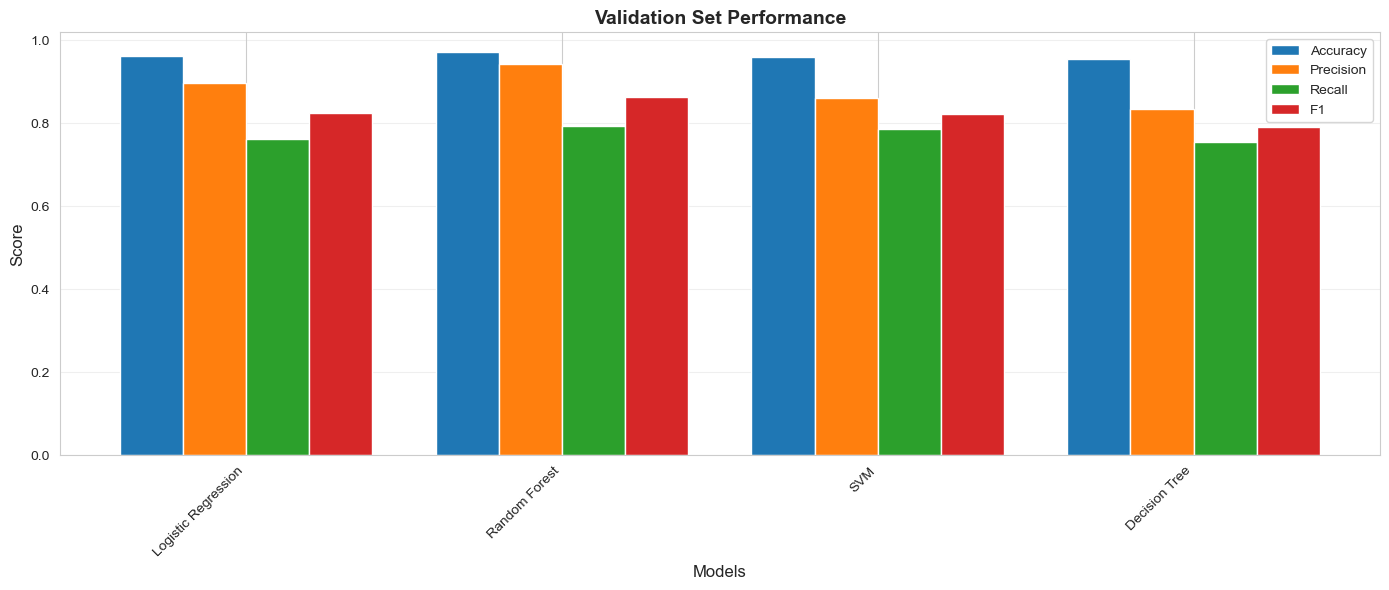

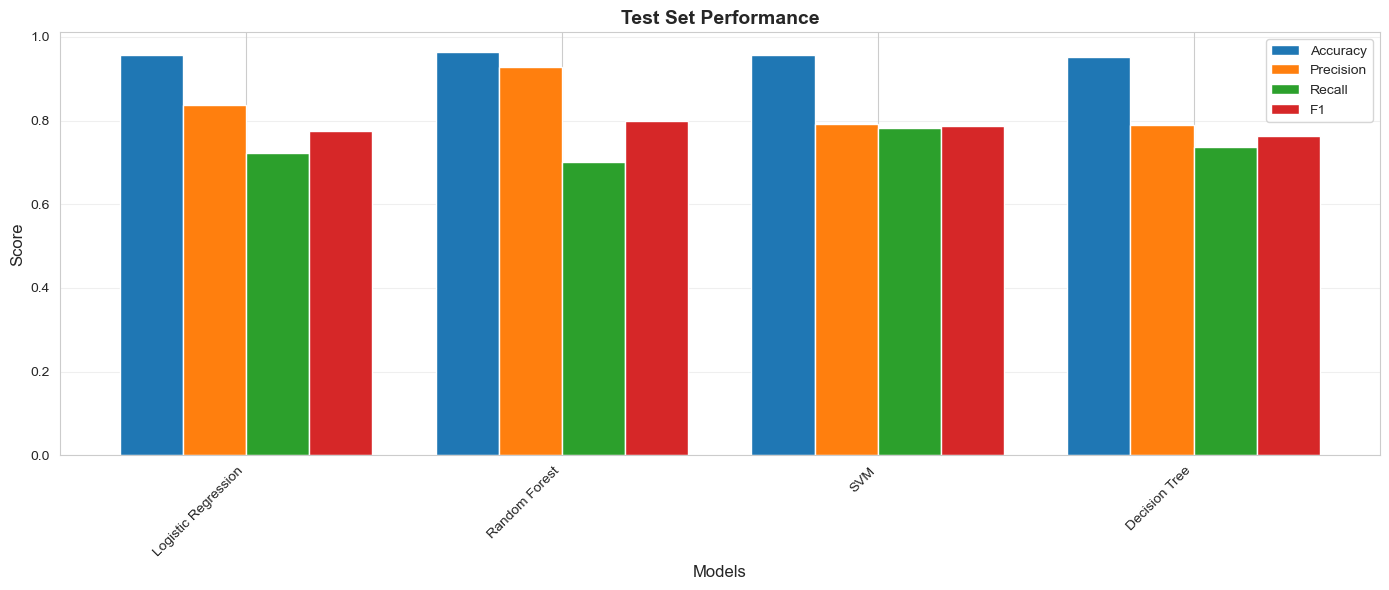

Model,Val_Accuracy,Val_F1,Test_Accuracy,Test_F1
Logistic Regression,0.9620,0.8240,0.9560,0.7756
Random Forest,0.9703,0.8621,0.9627,0.7979
SVM,0.9601,0.8216,0.9555,0.7872
Decision Tree,0.9537,0.7917,0.9517,0.7624


TASK 2 COMPLETED SUCCESSFULLY



In [8]:
def task_2_test():
    loader = DataLoader(
        train_path='data/English dataset/train.jsonl',
        test_path='data/English dataset/test.jsonl'
    )
    train_data, test_data = loader.load_all()
    
    task1 = Task1(train_data, test_data)
    train_df, val_df, test_df = task1.prepare_data(binary_labels=True)
    
    task2 = Task2(train_df, val_df, test_df)
    
    X_train, X_val, X_test, y_train, y_val, y_test = task2.prepare_text_features(
        max_features=5000
    )
    
    task2.train_logistic_regression(X_train, y_train, X_val, y_val)
    task2.train_random_forest(X_train, y_train, X_val, y_val)
    task2.train_svm(X_train, y_train, X_val, y_val)
    task2.train_decision_tree(X_train, y_train, X_val, y_val)
    
    test_results = task2.evaluate_on_test(X_test, y_test)
    
    task2.visualize_results(task2.results, test_results)

    return task2, test_results

task_2_test();

## Task 3: Transformer-based Classifier

For this task I formatted the data for transformer input by creating premise-hypothesis pairs with special tokens and converting them into Hugging Face Dataset objects. I loaded a pre-trained BERT model and configured it for binary sequence classification with a learning rate of 2e-5, batch size of 16 for training and 32 for evaluation. The training included early stopping with patience of 3 epochs and saved the best model based on validation F1-score. I fine-tuned the transformer using the Hugging Face Trainer API, which handled the training loop and computed metrics during evaluation, then evaluated the final model on the test set. The visualizations show a confusion matrix heatmap and a comparison table with the best ML baseline from Task 2 to highlight improvements from the transformer approach.

### Implementation

In [8]:
class Task3:
    def __init__(self, train_df, val_df, test_df, model_name='nlpaueb/legal-bert-base-uncased'):
        self.train_df = train_df.copy()
        self.val_df = val_df.copy()
        self.test_df = test_df.copy()
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        self.trainer = None
        self.results = {}
        
    def prepare_datasets(self, max_length=512):
        print(f"Preparing datasets for {self.model_name}")
        
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        
        def create_hf_dataset(df):
            return HFDataset.from_dict({
                'premise': df['premise'].tolist(),
                'hypothesis': df['hypothesis'].tolist(),
                'label': df['binary_label'].tolist()
            })
        
        train_dataset = create_hf_dataset(self.train_df)
        val_dataset = create_hf_dataset(self.val_df)
        test_dataset = create_hf_dataset(self.test_df)
        
        def tokenize_function(examples):
            return self.tokenizer(
                examples['premise'],
                examples['hypothesis'],
                truncation=True,
                padding='max_length',
                max_length=max_length
            )
        
        print("Tokenizing...")
        train_dataset = train_dataset.map(tokenize_function, batched=True)
        val_dataset = val_dataset.map(tokenize_function, batched=True)
        test_dataset = test_dataset.map(tokenize_function, batched=True)
        
        train_dataset = train_dataset.remove_columns(['premise', 'hypothesis'])
        val_dataset = val_dataset.remove_columns(['premise', 'hypothesis'])
        test_dataset = test_dataset.remove_columns(['premise', 'hypothesis'])
        
        train_dataset.set_format('torch')
        val_dataset.set_format('torch')
        test_dataset.set_format('torch')
        
        print(f"Train dataset: {len(train_dataset)}")
        print(f"Validation dataset: {len(val_dataset)}")
        print(f"Test dataset: {len(test_dataset)}\n")
        
        return train_dataset, val_dataset, test_dataset
    
    def compute_metrics(self, eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        
        return {
            'accuracy': accuracy_score(labels, predictions),
            'precision': precision_score(labels, predictions, zero_division=0),
            'recall': recall_score(labels, predictions, zero_division=0),
            'f1': f1_score(labels, predictions, zero_division=0)
        }
    
    def train_model(self, train_dataset, val_dataset, 
                    num_epochs=3, batch_size=16, learning_rate=2e-5,
                    warmup_steps=500, weight_decay=0.01,
                    output_dir='./results_task3'):
        print(f"Training {self.model_name}")
        
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=2
        )
        
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            warmup_steps=warmup_steps,
            weight_decay=weight_decay,
            logging_dir=f'{output_dir}/logs',
            logging_steps=100,
            eval_strategy='epoch',
            save_strategy='epoch',
            load_best_model_at_end=True,
            metric_for_best_model='f1',
            greater_is_better=True,
            save_total_limit=2,
            report_to='none',
            seed=42
        )
        
        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )
        
        print("Starting training...")
        self.trainer.train()
        print("Training completed\n")
        
        return self.trainer
    
    def evaluate_model(self, test_dataset):
        print("Evaluating on test set...")
        
        test_results = self.trainer.evaluate(test_dataset)
        
        predictions = self.trainer.predict(test_dataset)
        pred_labels = np.argmax(predictions.predictions, axis=1)
        true_labels = predictions.label_ids
        
        metrics = {
            'accuracy': accuracy_score(true_labels, pred_labels),
            'precision': precision_score(true_labels, pred_labels, zero_division=0),
            'recall': recall_score(true_labels, pred_labels, zero_division=0),
            'f1': f1_score(true_labels, pred_labels, zero_division=0)
        }
        
        pred_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
        metrics['roc_auc'] = roc_auc_score(true_labels, pred_probs)
        
        self.results = metrics
        
        cm = confusion_matrix(true_labels, pred_labels)
        
        return metrics, cm, pred_labels, true_labels
    
    def visualize_results(self, cm, task2_results=None):
        print("Generating visualizations\n")
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Not Contradiction', 'Contradiction'],
                    yticklabels=['Not Contradiction', 'Contradiction'])
        ax.set_title('Confusion Matrix - Transformer Model', fontsize=14, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=12)
        ax.set_xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        if task2_results is not None:
            fig, ax = plt.subplots(figsize=(14, 6))
            
            models = list(task2_results.keys()) + ['Legal-BERT']
            metrics_list = ['accuracy', 'precision', 'recall', 'f1']
            
            x = np.arange(len(models))
            width = 0.2
            
            for i, metric in enumerate(metrics_list):
                scores = []
                for model in models[:-1]:
                    scores.append(task2_results[model][metric])
                scores.append(self.results[metric])
                
                ax.bar(x + i * width, scores, width, label=metric.capitalize())
            
            ax.set_xlabel('Models', fontsize=12)
            ax.set_ylabel('Score', fontsize=12)
            ax.set_title('Model Comparison: Traditional ML vs Transformer', fontsize=14, fontweight='bold')
            ax.set_xticks(x + width * 1.5)
            ax.set_xticklabels(models, rotation=45, ha='right')
            ax.legend()
            ax.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        results_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
            'Score': [
                self.results['accuracy'],
                self.results['precision'],
                self.results['recall'],
                self.results['f1'],
                self.results['roc_auc']
            ]
        })
        
        html_table = results_df.to_html(index=False, float_format=lambda x: f'{x:.4f}')
        html_table = f"<h3>Transformer Model Performance</h3>{html_table}"
        html_table = html_table.replace('<table', '<table style="border-collapse: collapse; width: 100%;"')
        html_table = html_table.replace('<th>', '<th style="background-color: #3498db; color: white; padding: 10px;">')
        html_table = html_table.replace('<td>', '<td style="padding: 8px; border: 1px solid #ddd;">')
        
        display(HTML(html_table))
    
    def compare_with_traditional_ml(self, task2_results):
        comparison_data = []
        
        for model_name, metrics in task2_results.items():
            comparison_data.append({
                'Model': model_name,
                'Type': 'Traditional ML',
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1': metrics['f1'],
                'ROC AUC': metrics.get('roc_auc', 'N/A')
            })
        
        comparison_data.append({
            'Model': 'Legal-BERT',
            'Type': 'Transformer',
            'Accuracy': self.results['accuracy'],
            'Precision': self.results['precision'],
            'Recall': self.results['recall'],
            'F1': self.results['f1'],
            'ROC AUC': self.results['roc_auc']
        })
        
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df = comparison_df.sort_values('F1', ascending=False).reset_index(drop=True)
        
        html_table = comparison_df.to_html(index=False, float_format=lambda x: f'{x:.4f}' if isinstance(x, float) else x)
        html_table = f"<h3>Comprehensive Model Comparison</h3>{html_table}"
        html_table = html_table.replace('<table', '<table style="border-collapse: collapse; width: 100%;"')
        html_table = html_table.replace('<th>', '<th style="background-color: #2ecc71; color: white; padding: 10px;">')
        html_table = html_table.replace('<td>', '<td style="padding: 8px; border: 1px solid #ddd;">')
        
        display(HTML(html_table))
        
        return comparison_df

### Test

TASK 3: TRANSFORMER-BASED CLASSIFIER

Loading data from data/English dataset/train.jsonl
Loading data from data/English dataset/test.jsonl
Loaded 7191 training samples and 2091 test samples

Preparing and formatting data
Train set: 6112 samples
Validation set: 1079 samples
Test set: 2091 samples

Training Task 2 models for comparison...
Creating TF-IDF features
Feature matrix shape: (6112, 5000)

Training Logistic Regression
Best parameters: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l2'}
Validation F1: 0.8240

Training Random Forest
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Validation F1: 0.8621

Training SVM
Best parameters: {'C': 10.0, 'loss': 'squared_hinge'}
Validation F1: 0.8216

Training Decision Tree
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Validation F1: 0.7917

Evaluating models on test set

Logistic Regression - Test F1: 0.7756, Accuracy: 0.9560
Random Forest - Test F1: 0.7

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2091/2091 [00:00<00:00, 10082.31 examples/s]
'(ProtocolError('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')), '(Request ID: 14b6b830-9229-417f-a484-c452dddb6d4d)')' thrown while requesting HEAD https://huggingface.co/nlpaueb/legal-bert-base-uncased/resolve/main/config.json
Retrying in 1s [Retry 1/5].


Train dataset: 6112 samples
Validation dataset: 1079 samples
Test dataset: 2091 samples

Training nlpaueb/legal-bert-base-uncased
Epochs: 3, Batch size: 16, Learning rate: 2e-05



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.190800,0.124387,0.962929,0.930000,0.738095,0.823009
2,0.098100,0.076082,0.980538,0.920000,0.912698,0.916335
3,0.039500,0.077725,0.983318,0.915385,0.944444,0.929688


Training completed

Evaluating on test set...



Test Results:
Accuracy: 0.9747
Precision: 0.8920
Recall: 0.8636
F1 Score: 0.8776
ROC AUC: 0.9841

Generating visualizations



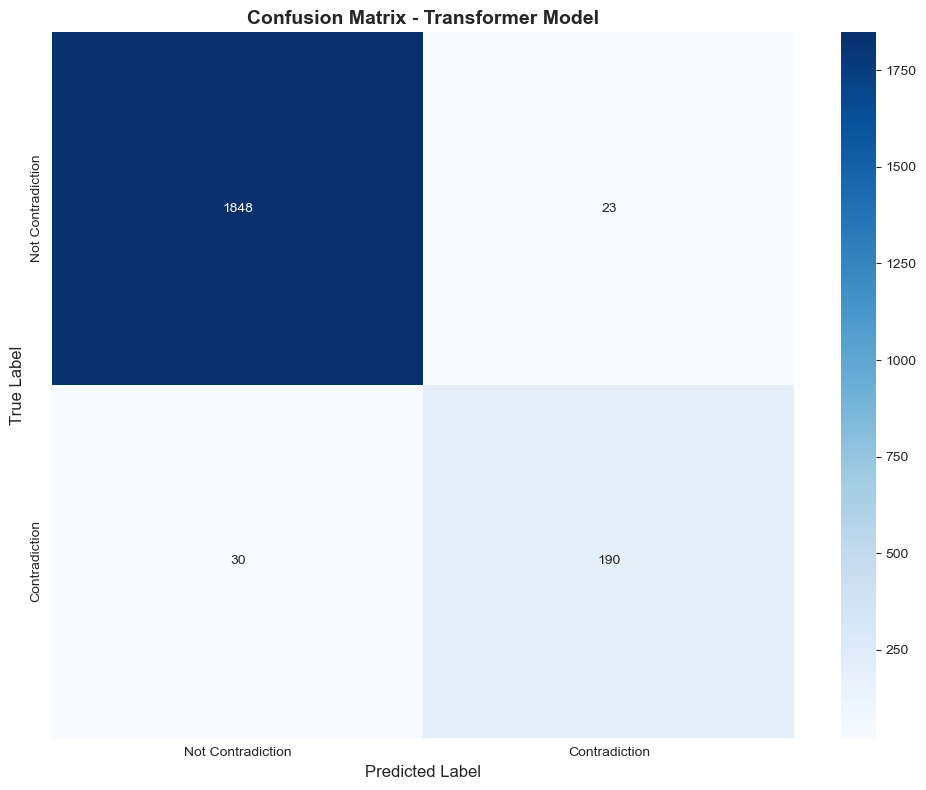

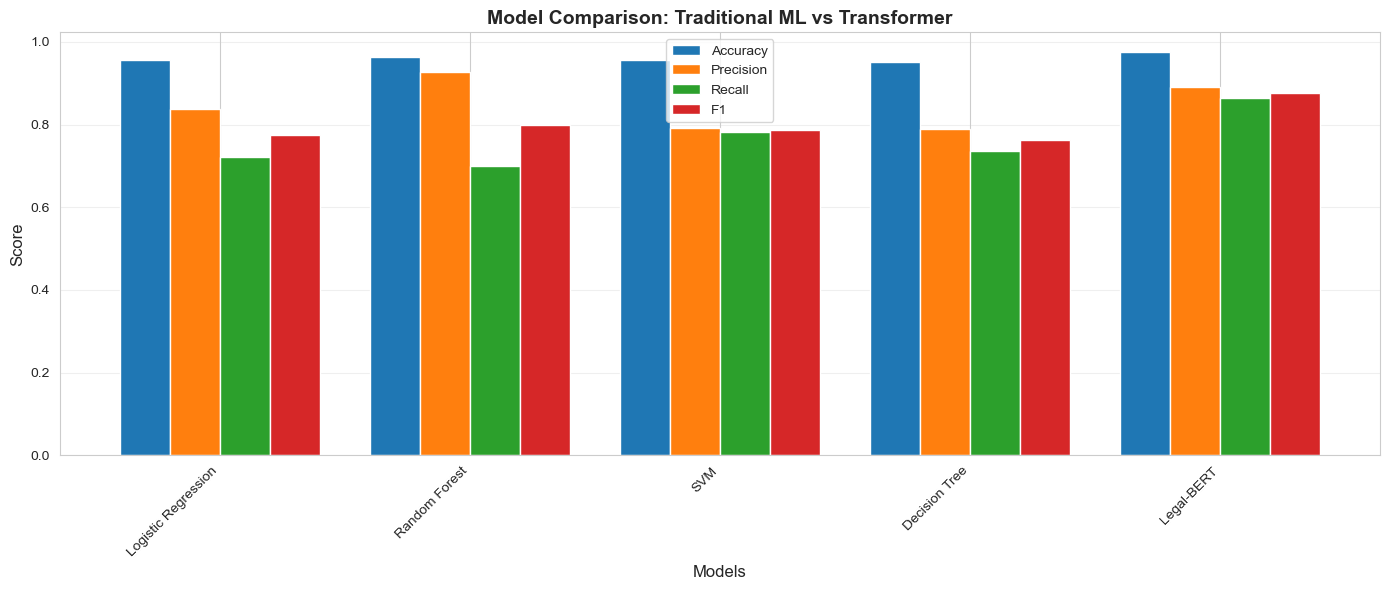

Metric,Score
Accuracy,0.9747
Precision,0.8920
Recall,0.8636
F1 Score,0.8776
ROC AUC,0.9841


Model,Type,Accuracy,Precision,Recall,F1,ROC AUC
Legal-BERT,Transformer,0.9747,0.8920,0.8636,0.8776,0.9841
Random Forest,Traditional ML,0.9627,0.9277,0.7000,0.7979,0.9830
SVM,Traditional ML,0.9555,0.7926,0.7818,0.7872,N/A
Logistic Regression,Traditional ML,0.9560,0.8368,0.7227,0.7756,0.9664
Decision Tree,Traditional ML,0.9517,0.7902,0.7364,0.7624,0.8588


TASK 3 COMPLETED SUCCESSFULLY



In [10]:
def task_3_test():    
    loader = DataLoader(
        train_path='data/English dataset/train.jsonl',
        test_path='data/English dataset/test.jsonl'
    )
    train_data, test_data = loader.load_all()
    
    task1 = Task1(train_data, test_data)
    train_df, val_df, test_df = task1.prepare_data(binary_labels=True)
    
    print("Training Task 2 models for comparison...")
    task2 = Task2(train_df, val_df, test_df)
    X_train, X_val, X_test, y_train, y_val, y_test = task2.prepare_text_features(max_features=5000)
    task2.train_logistic_regression(X_train, y_train, X_val, y_val)
    task2.train_random_forest(X_train, y_train, X_val, y_val)
    task2.train_svm(X_train, y_train, X_val, y_val)
    task2.train_decision_tree(X_train, y_train, X_val, y_val)
    task2_results = task2.evaluate_on_test(X_test, y_test)
    
    task3 = Task3(train_df, val_df, test_df, model_name='nlpaueb/legal-bert-base-uncased')
    
    train_dataset, val_dataset, test_dataset = task3.prepare_datasets(max_length=512)
    
    task3.train_model(
        train_dataset, 
        val_dataset,
        num_epochs=3,
        batch_size=16,
        learning_rate=2e-5
    )
    
    metrics, cm, pred_labels, true_labels = task3.evaluate_model(test_dataset)
    
    task3.visualize_results(cm, task2_results)
    
    comparison_df = task3.compare_with_traditional_ml(task2_results)
    
    return task3, metrics

task_3_test();

## Task 4: Sentence Embedding Model for Contradiction Search

For this task I created training examples for the sentence transformer by pairing contradicting texts as positive examples and non-contradicting texts as negative examples, formatted with similarity scores. I fine-tuned a sentence transformer based on Legal-BERT using CosineSimilarityLoss to learn embeddings where contradicting texts have high similarity, training for 2-4 epochs with validation monitoring. After training, I extracted all unique text sections from the datasets and encoded them using the trained model to create an embedding space for semantic search. I implemented a retrieval system that encodes a query text and computes cosine similarity with all corpus embeddings to find the top-k most similar potentially contradicting sections, then evaluated the system by measuring Recall@K (K=1,5,10,20) to see how often the true contradiction appears in the retrieved results. The visualizations show how Recall@K improves as K increases, a table with numerical scores, and three example queries with their retrieved results highlighting successful retrievals.

### Implementation

In [9]:
class Task4:    
    def __init__(self, train_df, val_df, test_df, base_model='nlpaueb/legal-bert-base-uncased'):
        self.train_df = train_df.copy()
        self.val_df = val_df.copy()
        self.test_df = test_df.copy()
        self.base_model = base_model
        self.model = None
        self.results = {}
        self.corpus_embeddings = None
        self.corpus_texts = None
        
    def prepare_training_data(self):
        print("Preparing training data for sentence transformer")
        
        train_examples = []
        for idx, row in self.train_df.iterrows():
            label = float(row['binary_label'])
            train_examples.append(InputExample(
                texts=[row['premise'], row['hypothesis']], 
                label=label
            ))
        
        val_examples = []
        for idx, row in self.val_df.iterrows():
            label = float(row['binary_label'])
            val_examples.append(InputExample(
                texts=[row['premise'], row['hypothesis']], 
                label=label
            ))
        
        print(f"Created {len(train_examples)} training examples")
        print(f"Created {len(val_examples)} validation examples\n")
        
        return train_examples, val_examples
    
    def train_sentence_transformer(self, train_examples, val_examples, 
                                   num_epochs=3, batch_size=16, 
                                   output_dir='./sentence_transformer_model'):
        print(f"Training Sentence Transformer based on {self.base_model}")
        print(f"Epochs: {num_epochs}, Batch size: {batch_size}\n")
        
        word_embedding_model = st_models.Transformer(self.base_model, max_seq_length=256)
        pooling_model = st_models.Pooling(word_embedding_model.get_word_embedding_dimension())
        
        self.model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
        
        device = 'cpu' # GPU was running out of memory
        if torch.cuda.is_available(): # I tried running this on nvidia cards
            device = 'cuda'
        elif torch.backends.mps.is_available():
            device = 'cpu'
        
        self.model = self.model.to(device)
        print(f"Using device: {device}\n")
        
        train_dataloader = STDataLoader(train_examples, shuffle=True, batch_size=batch_size)
        
        train_loss = losses.CosineSimilarityLoss(self.model)
        
        evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(
            val_examples, name='validation'
        )
        
        warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
        
        print("Starting training...")
        self.model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            evaluator=evaluator,
            epochs=num_epochs,
            evaluation_steps=500,
            warmup_steps=warmup_steps,
            output_path=output_dir,
            show_progress_bar=True
        )
        
        print("Training completed\n")
        
        return self.model
    
    def create_corpus_embeddings(self):
        print("Creating corpus embeddings for retrieval")
        
        all_df = pd.concat([self.train_df, self.val_df, self.test_df], ignore_index=True)
        
        all_premises = all_df['premise'].unique().tolist()
        all_hypotheses = all_df['hypothesis'].unique().tolist()
        
        self.corpus_texts = list(set(all_premises + all_hypotheses))
        
        print(f"Encoding {len(self.corpus_texts)} unique text sections...")
        self.corpus_embeddings = self.model.encode(
            self.corpus_texts, 
            convert_to_tensor=True,
            show_progress_bar=True,
            batch_size=32,
            device='cpu'
        )
        
        return self.corpus_embeddings, self.corpus_texts
    
    def retrieve_contradictions(self, query_text, k=5):
        query_embedding = self.model.encode(query_text, convert_to_tensor=True, device='cpu')
        
        cos_scores = torch.nn.functional.cosine_similarity(
            query_embedding.unsqueeze(0), 
            self.corpus_embeddings
        )
        
        top_results = torch.topk(cos_scores, k=min(k, len(self.corpus_texts)))
        
        results = []
        for score, idx in zip(top_results[0], top_results[1]):
            results.append({
                'text': self.corpus_texts[idx],
                'similarity_score': score.item(),
                'index': idx.item()
            })
        
        return results
    
    def evaluate_retrieval(self, test_df, k_values=[1, 5, 10]):
        print("Evaluating retrieval performance")
        
        results = {k: {'recall': 0, 'precision': 0, 'total': 0} for k in k_values}
        
        contradiction_pairs = test_df[test_df['binary_label'] == 1]
        
        print(f"Evaluating on {len(contradiction_pairs)} contradiction pairs\n")
        
        for idx, row in contradiction_pairs.iterrows():
            query = row['premise']
            true_contradiction = row['hypothesis']
            
            for k in k_values:
                retrieved = self.retrieve_contradictions(query, k=k)
                retrieved_texts = [r['text'] for r in retrieved]
                
                if true_contradiction in retrieved_texts:
                    results[k]['recall'] += 1
                
                results[k]['total'] += 1
        
        for k in k_values:
            if results[k]['total'] > 0:
                results[k]['recall'] = results[k]['recall'] / results[k]['total']
        
        self.results = results
        
        return results
    
    def visualize_results(self):
        print("Generating retrieval visualizations\n")
        
        k_values = sorted(self.results.keys())
        recall_scores = [self.results[k]['recall'] for k in k_values]
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(k_values, recall_scores, marker='o', linewidth=2, markersize=8, color='#2ecc71')
        ax.set_xlabel('K (Number of Retrieved Documents)', fontsize=12)
        ax.set_ylabel('Recall Score', fontsize=12)
        ax.set_title('Retrieval Performance: Recall@K', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(k_values)
        
        for k, recall in zip(k_values, recall_scores):
            ax.text(k, recall + 0.01, f'{recall:.3f}', ha='center', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        results_df = pd.DataFrame({
            'K': k_values,
            'Recall': recall_scores
        })
        
        html_table = results_df.to_html(index=False, float_format=lambda x: f'{x:.4f}')
        html_table = f"<h3>Retrieval Performance Metrics</h3>{html_table}"
        html_table = html_table.replace('<table', '<table style="border-collapse: collapse; width: 100%;"')
        html_table = html_table.replace('<th>', '<th style="background-color: #2ecc71; color: white; padding: 10px;">')
        html_table = html_table.replace('<td>', '<td style="padding: 8px; border: 1px solid #ddd;">')
        
        display(HTML(html_table))
    
    def demonstrate_retrieval(self, num_examples=3):
        print("Demonstrating retrieval with examples\n")
        
        test_contradictions = self.test_df[self.test_df['binary_label'] == 1].head(num_examples)
        
        for idx, row in test_contradictions.iterrows():
            query = row['premise']
            true_contradiction = row['hypothesis']
            
            retrieved = self.retrieve_contradictions(query, k=5)
            
            html = f"""
            <div style="border: 2px solid #3498db; padding: 15px; margin: 20px 0; border-radius: 5px;">
                <h4 style="color: #3498db;">Example Query:</h4>
                <p><b>Query Text:</b> {query[:300]}...</p>
                <p><b>True Contradiction:</b> {true_contradiction[:300]}...</p>
                <h4 style="color: #2ecc71;">Top 5 Retrieved Sections:</h4>
                <ol>
            """
            
            for i, result in enumerate(retrieved):
                color = '#2ecc71' if result['text'] == true_contradiction else '#95a5a6'
                marker = '✓ TRUE MATCH' if result['text'] == true_contradiction else ''
                html += f"""
                    <li style="margin: 10px 0;">
                        <b style="color: {color};">Similarity: {result['similarity_score']:.4f} {marker}</b><br>
                        {result['text'][:200]}...
                    </li>
                """
            
            html += """
                </ol>
            </div>
            """
            
            display(HTML(html))

### Test

TASK 4: SENTENCE EMBEDDING MODEL FOR CONTRADICTION SEARCH

Loading data from data/English dataset/train.jsonl
Loading data from data/English dataset/test.jsonl
Loaded 7191 training samples and 2091 test samples

Preparing and formatting data
Train set: 6112 samples
Validation set: 1079 samples
Test set: 2091 samples

Preparing training data for sentence transformer
Created 6112 training examples
Created 1079 validation examples

Training Sentence Transformer based on nlpaueb/legal-bert-base-uncased
Epochs: 2, Batch size: 8

MPS detected but using CPU to avoid memory issues
Using device: cpu

Starting training...


Step,Training Loss,Validation Loss,Validation Pearson Cosine,Validation Spearman Cosine
500,0.072400,No log,0.909795,0.530820
764,0.072400,No log,0.911586,0.540567
1000,0.022200,No log,0.922097,0.540743
1500,0.016200,No log,0.933149,0.545764
1528,0.016200,No log,0.933003,0.546052


Training completed

Creating corpus embeddings for retrieval
Encoding 4697 unique text sections...


Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [01:09<00:00,  2.12it/s]


Created embeddings with shape: torch.Size([4697, 768])

Evaluating retrieval performance
Evaluating on 220 contradiction pairs

Retrieval Results:
Recall@1: 0.0000
Recall@5: 0.0000
Recall@10: 0.0045
Recall@20: 0.0273

Generating retrieval visualizations



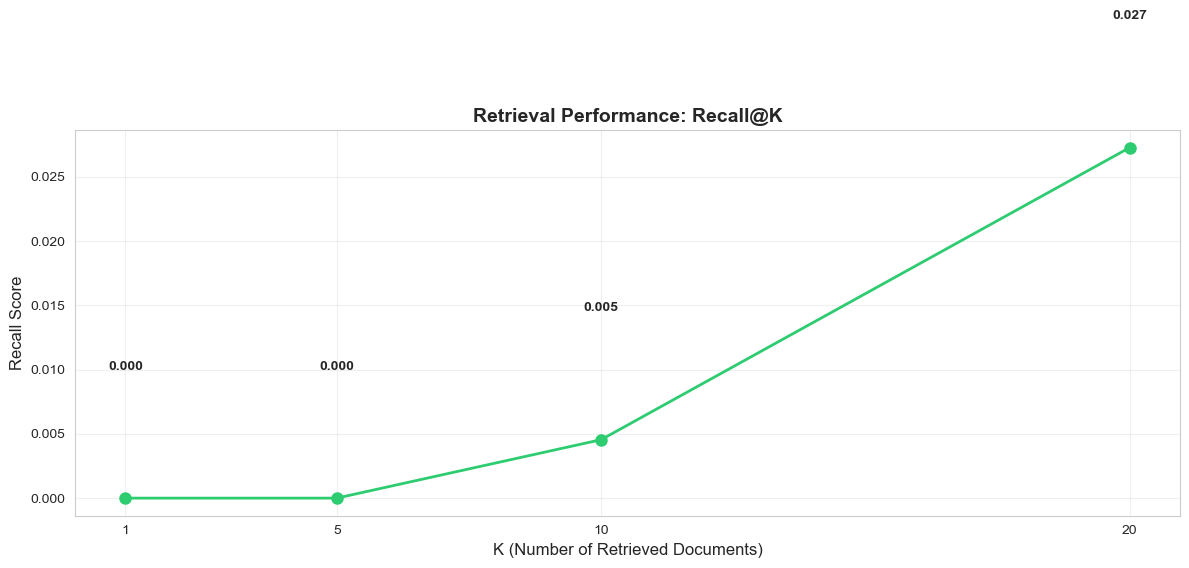

K,Recall
1,0.0000
5,0.0000
10,0.0045
20,0.0273


Demonstrating retrieval with examples



TASK 4 COMPLETED SUCCESSFULLY



In [11]:
def task_4_test():
    loader = DataLoader(
        train_path='data/English dataset/train.jsonl',
        test_path='data/English dataset/test.jsonl'
    )
    train_data, test_data = loader.load_all()
    
    task1 = Task1(train_data, test_data)
    train_df, val_df, test_df = task1.prepare_data(binary_labels=True)
    
    task4 = Task4(train_df, val_df, test_df, base_model='nlpaueb/legal-bert-base-uncased')
    
    train_examples, val_examples = task4.prepare_training_data()
    
    task4.train_sentence_transformer(
        train_examples,
        val_examples,
        num_epochs=2,
        batch_size=8
    )
    
    corpus_embeddings, corpus_texts = task4.create_corpus_embeddings()
    
    retrieval_results = task4.evaluate_retrieval(test_df, k_values=[1, 5, 10, 20])
    
    task4.visualize_results()
    
    task4.demonstrate_retrieval(num_examples=3)
    
    return task4, retrieval_results

task_4_test();

## Conclusion

This assignment demonstrated the progression from traditional machine learning to modern deep learning approaches for legal contradiction detection. Task 5, which requires comprehensive results and reporting, has been integrated throughout all previous tasks with detailed performance metrics, comparison tables, and visualizations accompanying each approach, providing a complete analysis of model performance across all methods.